In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, Float
from sqlalchemy.orm import sessionmaker, relationship, declarative_base
import sqlparse
from langchain_core.runnables.config import RunnableConfig


load_dotenv()

# DATABASE_URL = os.getenv("DATABASE_URL", "sqlite:///example.db")
engine = create_engine("sqlite:///data/sql/bank_domain.db")

SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)

Base = declarative_base()

In [2]:
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
# from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sqlalchemy import text, inspect
from langgraph.graph import StateGraph, END

from langchain_groq import ChatGroq

In [ ]:
llm = ChatGroq(
    temperature = 0,
    groq_api_key = os.getenv("groq_api_key"),
    model_name = os.getenv("llama_model_name")
)

In [4]:
def get_database_schema(engine):
    inspector = inspect(engine)
    schema = ""
    for table_name in inspector.get_table_names():
        schema += f"Table: {table_name}\n"
        for column in inspector.get_columns(table_name):
            col_name = column["name"]
            col_type = str(column["type"])
            if column.get("primary_key"):
                col_type += ", Primary Key"
            if column.get("foreign_keys"):
                fk = list(column["foreign_keys"])[0]
                col_type += f", Foreign Key to {fk.column.table.name}.{fk.column.name}"
            schema += f"- {col_name}: {col_type}\n"
        schema += "\n"
    print("Retrieved database schema.")
    return schema

print(get_database_schema(engine))

Retrieved database schema.
Table: accounts
- account_id: INTEGER, Primary Key
- customer_id: INTEGER
- account_type: TEXT
- balance: REAL
- open_date: DATE

Table: branch_locations
- branch_id: INTEGER, Primary Key
- branch_name: TEXT
- address: TEXT
- city: TEXT
- state: TEXT
- zip_code: TEXT

Table: credit_cards
- card_id: INTEGER, Primary Key
- customer_id: INTEGER
- card_type: TEXT
- credit_limit: REAL
- current_balance: REAL

Table: credit_exposures
- exposure_id: INTEGER, Primary Key
- customer_id: INTEGER
- exposure_type: TEXT
- exposure_amount: REAL
- risk_level: TEXT

Table: customers
- customer_id: INTEGER, Primary Key
- first_name: TEXT
- last_name: TEXT
- date_of_birth: DATE
- email: TEXT
- phone: TEXT
- address: TEXT
- credit_score: INTEGER

Table: employees
- employee_id: INTEGER, Primary Key
- first_name: TEXT
- last_name: TEXT
- position: TEXT
- branch_id: INTEGER
- hire_date: DATE

Table: insurance_policies
- policy_id: INTEGER, Primary Key
- customer_id: INTEGER
- pol

In [5]:
class AgentState(TypedDict):
    question: str
    sql_query: str
    query_result: str
    query_rows: list
    current_user: str
    attempts: int
    relevance: str
    sql_error: bool

In [6]:
class GetCurrentUser(BaseModel):
    current_user: str = Field(
        description="The name of the current user based on the provided user ID."
    )

def get_current_user(state: AgentState, config: RunnableConfig):
    print("Retrieving the current user based on user ID.")
    user_id = config["configurable"].get("current_user_id", None)
    if not user_id:
        state["current_user"] = "User not found"
        print("No user ID provided in the configuration.")
        return state

    session = SessionLocal()
    try:
        user = session.query(User).filter(User.id == int(user_id)).first()
        if user:
            state["current_user"] = user.name
            print(f"Current user set to: {state['current_user']}")
        else:
            state["current_user"] = "User not found"
            print("User not found in the database.")
    except Exception as e:
        state["current_user"] = "Error retrieving user"
        print(f"Error retrieving user: {str(e)}")
    finally:
        session.close()
    return state

In [7]:
class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

def check_relevance(state: AgentState, config: RunnableConfig):
    question = state["question"]
    schema = get_database_schema(engine)
    print(f"Checking relevance of the question: {question}")
    system = """You are an assistant that determines whether a given question is related to the following database schema.
    
    Schema:
    {schema}

    Respond with only "relevant" or "not_relevant".
    """.format(schema=schema)
    human = f"Question: {question}"
    check_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human),
        ]
    )
    llm = ChatGroq(
        temperature = 0,
        groq_api_key = os.getenv("groq_api_key"),
        model_name = os.getenv("llama_model_name1")
        )

    structured_llm = llm.with_structured_output(CheckRelevance)
    relevance_checker = check_prompt | structured_llm
    relevance = relevance_checker.invoke({})
    state["relevance"] = relevance.relevance
    print(f"Relevance determined: {state['relevance']}")
    return state

In [8]:
class ConvertToSQL(BaseModel):
    sql_query: str = Field(
        description="The SQL query corresponding to the user's natural language question."
    )

def convert_nl_to_sql(state: AgentState, config: RunnableConfig):
    question = state["question"]
    # current_user = state["current_user"]
    schema = get_database_schema(engine)
    print(f"Converting question to SQL for user : {question}")
    system = """
    You are a SQL expert with a strong attention to detail.
    Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

    When generating the query:

    1. Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.

    2. You can order the results by a relevant column to return the most interesting examples in the database.

    3. Never query for all the columns from a specific table, only ask for the relevant columns given the question.

    4. If you get an error while executing a query, rewrite the query and try again.

    5. If you get an empty result set, you should try to rewrite the query to get a non-empty result set.

    6. NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

    7. DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database. Do not return any sql query except answer.
    
    You are an assistant that converts natural language questions into SQL queries based on the following schema:
    
    {schema}

    Ensure that all query-related data is scoped to the user.

    Provide only the SQL query without any explanations. Alias columns appropriately to match the expected keys in the result.

    For example, alias 'food.name' as 'food_name' and 'food.price' as 'price'.
    """.format(schema=schema) #, current_user=current_user)

    convert_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Question: {question}"),
        ]
    )

    llm = ChatGroq(
        temperature = 0,
        groq_api_key = os.getenv("groq_api_key"),
        model_name = os.getenv("llama_model_name1")
        )
    
    structured_llm = llm.with_structured_output(ConvertToSQL)
    sql_generator = convert_prompt | structured_llm
    result = sql_generator.invoke({"question": question})
    state["sql_query"] = result.sql_query
    print(f"Generated SQL query: {state['sql_query']}")
    return state

def execute_sql(state: AgentState):
    sql_query = state["sql_query"].strip()
    session = SessionLocal()
    print(f"Executing SQL query: {sql_query}")
    try:
        result = session.execute(text(sql_query))
        if sql_query.lower().startswith("select"):
            rows = result.fetchall()
            columns = result.keys()
            if rows:
                header = ", ".join(columns)
                state["query_rows"] = [dict(zip(columns, row)) for row in rows]
                # Format the result for readability
                data = "; ".join([
                    ", ".join(f"{key}: {value}" for key, value in row.items())  # Dynamically format each row
                    for row in state["query_rows"]
                    ])
                formatted_result = f"{header}\n{data}"
            else:
                state["query_rows"] = []
                formatted_result = "No results found."
            state["query_result"] = formatted_result
            # print(f"******query_result => {state["query_result"]}******")
            state["sql_error"] = False
            print(f"SQL SELECT query executed successfully. {state["query_result"]}")
        else:
            session.commit()
            state["query_result"] = "The action has been successfully completed."
            state["sql_error"] = False
            print("SQL command executed successfully.")
    except Exception as e:
        state["query_result"] = f"Error executing SQL query: {str(e)}"
        state["sql_error"] = True
        print(f"Error executing SQL query: {str(e)}")
    finally:
        session.close()
    return state

def generate_human_readable_answer(state: AgentState):
    sql = state["sql_query"]
    result = state["query_result"]
    # current_user = state["current_user"]
    query_rows = state.get("query_rows", [])
    sql_error = state.get("sql_error", False)
    print("Generating a human-readable answer.")

    system = """You are an assistant that converts SQL query results into clear, natural language responses."""
    if sql_error:
        # Directly relay the error message
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SQL Query:
                    {sql}

                    Result:
                    {result}

                    Formulate a clear and understandable error message in a single sentence, starting with 'Hello user,' informing them about the issue."""
                ),
            ]
        )
    elif sql.lower().startswith("select"):
        if not query_rows:
            # Handle cases with no orders
            generate_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        f"""SQL Query:
                        {sql}

                        Result:
                        {result}

                        Summarize the answer in the human readable format. Create a concise summary."""
                    ),
                ]
            )
        else:
            # Handle displaying orders
            generate_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        f"""SQL Query:
                        {sql}

                        Result:
                        {result}

                        Formulate a clear and understandable answer to the original question """
                    ),
                ]
            )
    else:
        # Handle non-select queries
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SQL Query:
                    {sql}

                    Result:
                    {result}

                    Formulate a clear and understandable confirmation message in a single sentence""" 
                ),
            ]
        )
 
    llm = ChatGroq(
        temperature = 0,
        groq_api_key = os.getenv("groq_api_key"),
        model_name = os.getenv("llama_model_name1")
        )

    human_response = generate_prompt | llm | StrOutputParser()
    answer = human_response.invoke({})
    state["query_result"] = answer
    print("Generated human-readable answer.")
    return state

In [9]:
class RewrittenQuestion(BaseModel):
    question: str = Field(description="The rewritten question.")

def regenerate_query(state: AgentState):
    question = state["question"]
    print("Regenerating the SQL query by rewriting the question.")
    system = """You are an assistant that reformulates an original question to enable more precise SQL queries. Ensure that all necessary details, such as table joins, 
    are preserved to retrieve complete and accurate data.
    """
    rewrite_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                f"Original Question: {question}\nReformulate the question to enable more precise SQL queries, ensuring all necessary details are preserved.",
            ),
        ]
    )

    llm = ChatGroq(
        temperature = 0,
        groq_api_key = os.getenv("groq_api_key"),
        model_name = os.getenv("llama_model_name1")
    )

    structured_llm = llm.with_structured_output(RewrittenQuestion)
    rewriter = rewrite_prompt | structured_llm
    rewritten = rewriter.invoke({})
    state["question"] = rewritten.question
    state["attempts"] += 1
    print(f"Rewritten question: {state['question']}")
    return state

In [10]:
def generate_funny_response(state: AgentState):
    print("Generating a funny response for an unrelated question.")
    system = """You are a SQL expert with a strong attention to detail.
    And you have got asked the ir-relevant question respect to the database.
    I this scenario please notify the user to ask the question related to the database.
    """
    # human_message = "I can not help with that, but doesn't asking questions make you hungry? You can always order something delicious."
    human_message = "Query was not relevant to the database. Please ask query related to the database."
    funny_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human_message),
        ]
    )
    llm = ChatGroq(
    temperature = 0.7,
    groq_api_key = os.getenv("groq_api_key"),
    model_name = os.getenv("llama_model_name1")
)
    funny_response = funny_prompt | llm | StrOutputParser()
    message = funny_response.invoke({})
    state["query_result"] = message
    print("Generated funny response.")
    return state

def end_max_iterations(state: AgentState):
    state["query_result"] = "Please try again."
    print("Maximum attempts reached. Ending the workflow.")
    return state

def relevance_router(state: AgentState):
    if state["relevance"].lower() == "relevant":
        return "convert_to_sql"
    else:
        return "generate_funny_response"

def check_attempts_router(state: AgentState):
    if state["attempts"] < 3:
        return "convert_to_sql"
    else:
        return "end_max_iterations"

def execute_sql_router(state: AgentState):
    if not state.get("sql_error", False):
        return "generate_human_readable_answer"
    else:
        return "regenerate_query"

In [11]:
def main():
    workflow = StateGraph(AgentState)

    # workflow.add_node("get_current_user", get_current_user)
    workflow.add_node("check_relevance", check_relevance)
    workflow.add_node("convert_to_sql", convert_nl_to_sql)
    workflow.add_node("execute_sql", execute_sql)
    workflow.add_node("generate_human_readable_answer", generate_human_readable_answer)
    workflow.add_node("regenerate_query", regenerate_query)
    workflow.add_node("generate_funny_response", generate_funny_response)
    workflow.add_node("end_max_iterations", end_max_iterations)

    # workflow.add_edge("get_current_user", "check_relevance")

    workflow.add_conditional_edges(
        "check_relevance",
        relevance_router,
        {
            "convert_to_sql": "convert_to_sql",
            "generate_funny_response": "generate_funny_response",
        },
    )

    workflow.add_edge("convert_to_sql", "execute_sql")

    workflow.add_conditional_edges(
        "execute_sql",
        execute_sql_router,
        {
            "generate_human_readable_answer": "generate_human_readable_answer",
            "regenerate_query": "regenerate_query",
        },
    )

    workflow.add_conditional_edges(
        "regenerate_query",
        check_attempts_router,
        {
            "convert_to_sql": "convert_to_sql",
            "max_iterations": "end_max_iterations",
        },
    )

    workflow.add_edge("generate_human_readable_answer", END)
    workflow.add_edge("generate_funny_response", END)
    workflow.add_edge("end_max_iterations", END)

    workflow.set_entry_point("check_relevance")

    app = workflow.compile()

    return app

In [12]:
app = main()

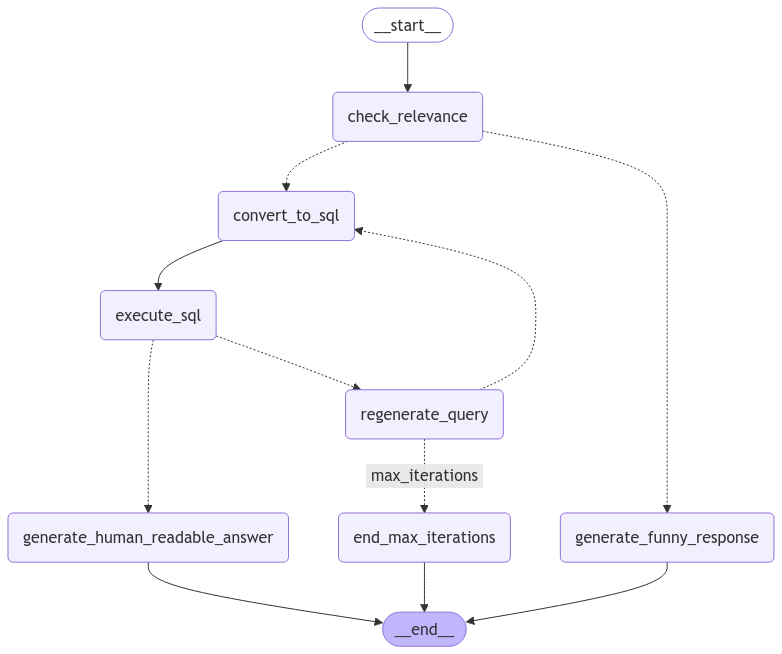

In [13]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [14]:
fake_config = {"configurable": {"current_user_id": "1"}}

In [15]:
# user_question = "What are the names and addresses of all customers who have a credit score above 750 and have at least one loan with a status of 'Active',  sorted by credit score descending?"
# user_question = "What is the average balance of accounts opened in the last six months, categorized by account type and broken down by the state of the branch the associated customer is linked to, via employee records?"
# user_question = "For each loan type, what is the total amount loaned, the average interest rate, and the percentage of loans that are currently 'Active'?"
user_question = "What is weather in pune today?"
result_1 = app.invoke({"question": user_question, "attempts": 0}, config=fake_config)


Retrieved database schema.
Checking relevance of the question: What is weather in pune today?
Relevance determined: not_relevant
Generating a funny response for an unrelated question.
Generated funny response.


In [ ]:
# print(result_1['relevance'])
# print(result_1['query_result'])

not_relevant
I apologize, but I didn't receive a query from you. It seems you're trying to ask a question, but it's not related to the database. 

To assist you better, could you please rephrase or ask a new question that is relevant to databases or SQL? I'll be happy to help you with any database-related queries or issues you're facing.


In [17]:
# print(f"SQL Query:\n{result_1["sql_query"]} \n\nAnswer:\n{result_1["query_result"]}")
if result_1['relevance'] == 'relevant':
    print(f"SQL Query:\n{sqlparse.format(result_1["sql_query"], reindent=True, keyword_case='upper')} \n\nAnswer:\n{result_1["query_result"]}")
elif result_1['relevance'] == 'not_relevant':
    print(f"Answer:\n{result_1["query_result"]}")

Answer:
I apologize, but I didn't receive a query from you. It seems you're trying to ask a question, but it's not related to the database. 

To assist you better, could you please rephrase or ask a new question that is relevant to databases or SQL? I'll be happy to help you with any database-related queries or issues you're facing.


In [18]:
# import sqlparse

# query = "SELECT bl.branch_name, COUNT(c.customer_id) AS customer_count, CASE WHEN c.credit_score BETWEEN 600 AND 650 THEN '600-650' WHEN c.credit_score BETWEEN 651 AND 700 THEN '651-700' WHEN c.credit_score BETWEEN 701 AND 750 THEN '701-750' WHEN c.credit_score BETWEEN 751 AND 800 THEN '751-800' ELSE 'Unknown' END AS credit_score_range, AVG(a.balance) AS avg_balance FROM customers c JOIN accounts a ON c.customer_id = a.customer_id JOIN employees e ON c.customer_id = e.branch_id JOIN branch_locations bl ON e.branch_id = bl.branch_id GROUP BY bl.branch_name, credit_score_range ORDER BY bl.branch_name, credit_score_range LIMIT 5"
# formatted_query = sqlparse.format(query, reindent=True, keyword_case='upper')

# print(formatted_query)